# <font color='red'>Data Science Project </font>

# PART ONE: Data Wrangling

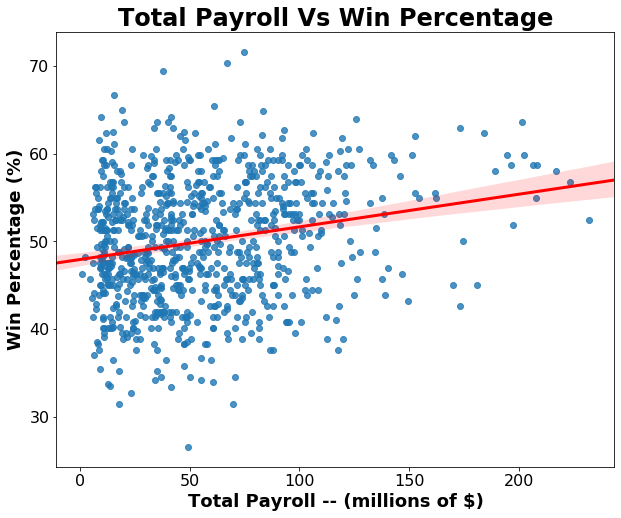

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Create a SQL connection
con = sqlite3.connect("lahman2014.sqlite")

# Get data from Teams & Salaries Tables (1990-2014)
Teams = pd.read_sql_query("SELECT yearID,teamID,G,W FROM Teams WHERE yearID >= 1985", con)
Salaries = pd.read_sql_query("SELECT yearID,teamID,salary FROM Salaries WHERE yearID >= 1985",con)

# CLose Connection
con.close()

# Calculate Winning Percentage for each team
Teams['Win_Percentage'] = Teams['W']/Teams['G']*100
Teams.drop(columns = ['G','W'],inplace=True)

# Calculate Total Payroll for each team
Salaries = Salaries.groupby(['yearID','teamID'],as_index=False).agg({'salary':'sum'})

# Merging Dataframes
DF = pd.merge(Teams,Salaries,left_on=['yearID','teamID'],right_on=['yearID','teamID'],how='inner')
DF = DF.sort_values(["yearID", "teamID"], ascending = (True, True)).reset_index(drop=True)
DF.rename(columns = {'salary':'Total_Payroll'},inplace=True)


# Convert Payrolls to Million ($) for simplicity
DF.Total_Payroll = DF.Total_Payroll/1000000 
DF

# Plot Relation between Payroll & Win Percentage
%matplotlib inline
fig,ax = plt.subplots(figsize=(10,8))
X = DF.Total_Payroll
Y = DF.Win_Percentage

sns.regplot(x='Total_Payroll', y='Win_Percentage', data=DF, truncate=False, line_kws={"color":"red","lw":3})
ax.set_title("Total Payroll Vs Win Percentage",fontsize=24,fontweight='bold')
ax.set_xlabel("Total Payroll -- (millions of $)", fontsize=18, fontweight='bold')
ax.set_ylabel("Win Percentage (%)",fontsize=18,fontweight='bold')
ax.tick_params(labelsize=16)
plt.show()
fig.savefig("Normal_Payroll.png")

### <font color='red'>Comments on Missing Data</font>
* We are collecting data from __Teams table__ AND __Salaries table,__ but we only have Salary Data from __1985__ while we have data on teams since __1871.__ 

* Therefore we will be __missing__ all of the teams from 1871 to 1984 in our table when we join teams with total team payrolls.
* So, we will only consider __Teams for which Salary and Team's payrolls do exist__, and ignore teams that   do not have information about payroll.

# PART TWO: Exploratory Data Analysis

## Payroll distribution

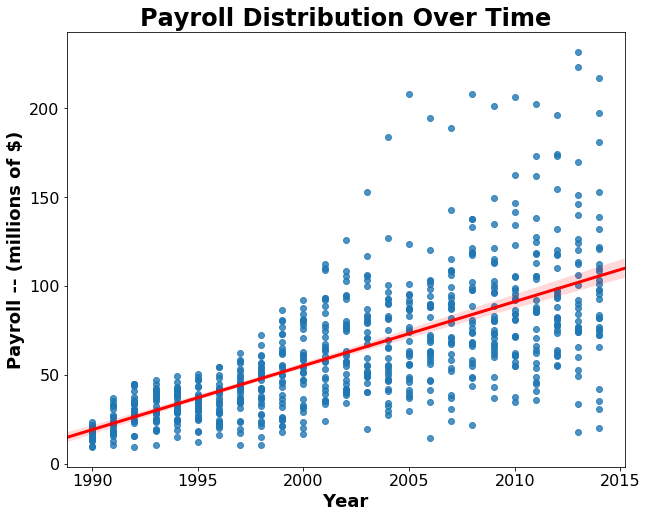

In [11]:
# Select data from 1990 to 2014
DF = DF[DF.yearID >= 1990].reset_index(drop=True)

# Payroll Distribution for all Teams together
fig,ax1 = plt.subplots(figsize=(10,8))
sns.regplot(x='yearID', y='Total_Payroll', data=DF, truncate=False, line_kws={"color":"red","lw":3})
ax1.set_title("Payroll Distribution Over Time",fontsize=24,fontweight='bold')
ax1.set_xlabel("Year", fontsize=18, fontweight='bold')
ax1.set_ylabel("Payroll -- (millions of $)",fontsize=18,fontweight='bold')
ax1.tick_params(labelsize=16)
fig.savefig("Payroll_Distribution.png")

## <font color='red'>Comments on plot</font>
* As we can see in the plot above, There is a __positive correlation__ between years and payroll of teams.
* The Team's Payroll tends to __increase__ over time.

count    728.000000
mean      63.397935
std       38.203617
min        9.373044
25%       35.023250
50%       55.313700
75%       83.896749
max      231.978886
Name: Total_Payroll, dtype: float64

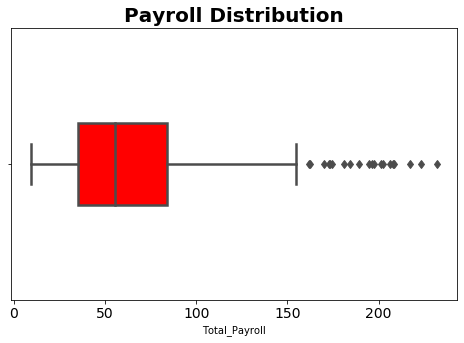

In [12]:
# Statistics concerned with Payroll Distribution
fig2,ax2 = plt.subplots(figsize=(8, 5))
sns.boxplot(DF.Total_Payroll,color='red', width=0.3, saturation=1, linewidth=2.5, fliersize=6)
ax2.set_title("Payroll Distribution",fontsize=20,fontweight='bold')
ax2.tick_params(labelsize=14)
fig2.savefig("Payroll Distribution Box-Plot.png");
DF.Total_Payroll.describe()  # Statistics of payrolls (Mean-Median-Min-Max-IQR..)

## <font color='red'>Comments on Payroll Distribution</font>
* We can see from the previous plots & statistics above that (Mean = 63.4 Millions) and the (Median = 55.3 Millions); As __Mean >   Median__; We can summarize that the payroll distribution is __Skewed to the right.__
* As Payroll's __(Standard Deviation = 38.2)__ and (Range = 222.61) ; we can observe that Payroll's data is __Widely Spread.__
* From the Box-Plot, we can see that there exist some __Outliers__ in ( Payrolls __> \\$157.21 Millions__).

## Correlation between Payroll and Winning percentage

In [13]:
# Cut Data frame into 5 time periods
group_names = ['[1990-1994]', '[1995-1999]', '[2000-2004]','[2005-2009]', '[2010-2014]']
DF['Time_Period'] = pd.cut(DF.yearID, 5, labels=group_names,include_lowest=True)

# Grouped Data
Periods = DF[['Time_Period','Win_Percentage','Total_Payroll','teamID']]
Periods = Periods.groupby(['Time_Period','teamID'],as_index=False).mean()
Periods.Win_Percentage.fillna(Periods.Win_Percentage.mean(),inplace=True)
Periods.Total_Payroll.fillna(Periods.Total_Payroll.mean(),inplace=True)
Periods

,Time_Period,teamID,Win_Percentage,Total_Payroll
0,[1990-1994],ANA,49.835506,62.450971
1,[1990-1994],ARI,49.835506,62.450971
2,[1990-1994],ATL,56.497726,31.721853
3,[1990-1994],BAL,50.444080,23.785204
4,[1990-1994],BOS,49.514761,34.863217
...,...,...,...,...
170,[2010-2014],SLN,55.679012,104.445659
171,[2010-2014],TBA,54.992047,60.558983
172,[2010-2014],TEX,53.881694,98.567688
173,[2010-2014],TOR,48.888889,87.203840


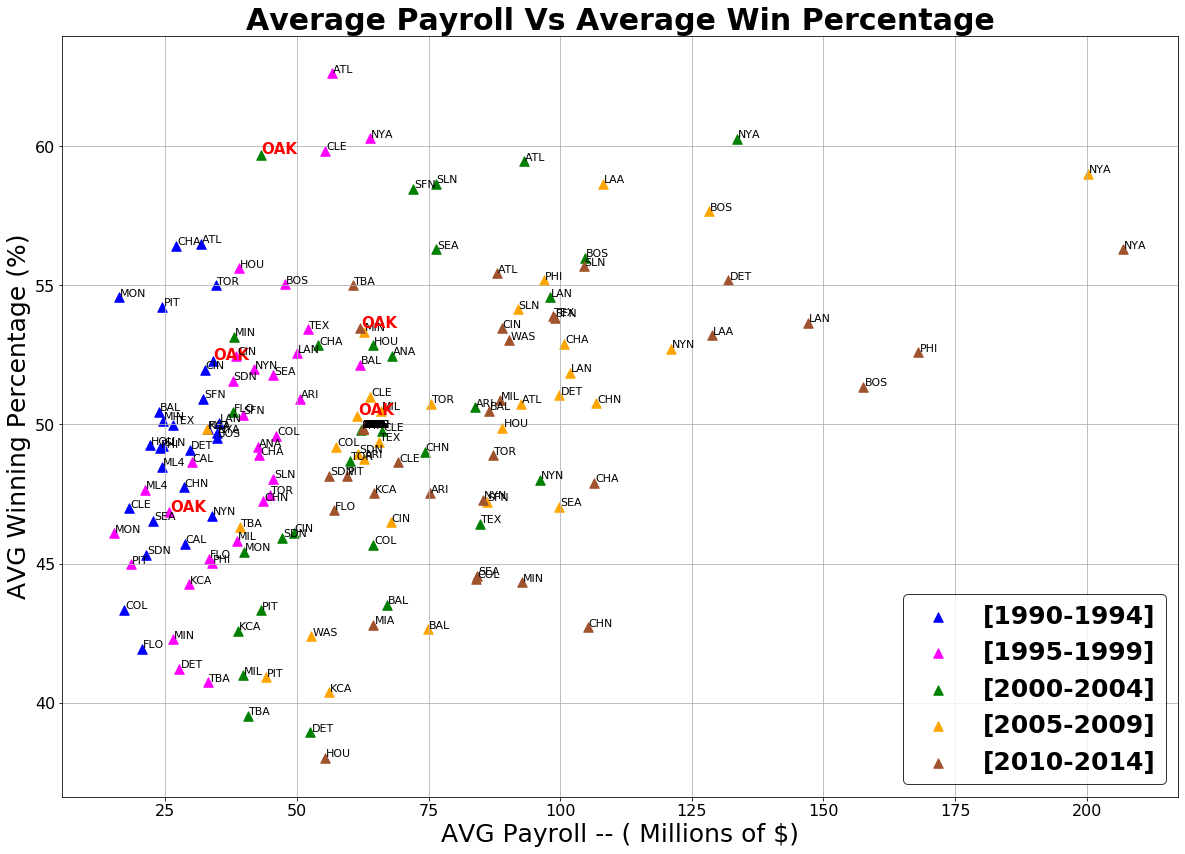

In [14]:
fig3,ax3 = plt.subplots(figsize=(20,14))
X = Periods.Total_Payroll
Y = Periods.Win_Percentage

colors = {'[1990-1994]':'blue', '[1995-1999]':'magenta', '[2000-2004]':'green', '[2005-2009]':'orange','[2010-2014]':'sienna'}
grouped = Periods.groupby('Time_Period')

for key, group in grouped:
    group.plot(ax=ax3, kind='scatter', x='Total_Payroll', y='Win_Percentage', label=key, color=colors[key], s=90,marker='^')
    
ax3.legend(loc='best',prop={'weight':'bold','size':25}, frameon=True,edgecolor='black')
ax3.set_title("Average Payroll Vs Average Win Percentage",fontsize=30,fontweight='bold')
ax3.set_xlabel("AVG Payroll -- ( Millions of $)",fontsize=25)
ax3.set_ylabel("AVG Winning Percentage (%)",fontsize=25)
ax3.tick_params(labelsize=16)

# Annotations
for i, txt in enumerate(Periods.teamID):
    # Oaklands
    if txt == "OAK":
        ax3.annotate(txt, (X[i], Y[i]), 
        xytext=(1, 1),
        textcoords='offset points',
        fontsize='15',
        fontweight='bold',
        color='red') 
    
    # Other Teams
    else:  
        ax3.annotate(txt, (X[i], Y[i]), 
        xytext=(1, 1),
        textcoords='offset points',
        fontsize='11',
        color='black')
        
# fig2.tight_layout()
plt.grid(True)   
fig3.savefig("Average Payroll Vs Average Winning Percentage.png");

### <font color='red'>Comments on plot</font>
1) It appears that on average, the __spread__ of the average payroll of teams __increases__ as they are paying their players more and more as time goes on.<br>
2) The __Total Payroll__ and the __Winning Percentage__ of teams are __weakly correlated.__

#### <font color='red'>Q1 : Are there any teams that stand out as being particularly good at paying for wins across these periods? </font>
1) Yes, We can see that __OAK__'s paying for wins across these periods is __efficient.__<br>
2) They were doing better than their counterparts who were spending the same amount of money __(They were winning more for less payroll).__

#### <font color='red'>Q2 : What can you say about the Oakland A's spending efficiency across these periods? </font>
 1) As we can see in the plot Oakland A's __(OAK)__'s Payroll started __like any other team__ from 1990 to 2000.<br>
 2) Across time, the team's payroll __spread__ has not changed a much (always __below__ or __near the mean Payroll).__<br>
 3) But despite this fact it's __winning rate was perfect__ especially from __(2000-2004)__ : Their win rate is almost the same as __NYA__ whose payroll is __<br> three times greater than OAK's Payroll).__<br>
 4) Summarizing all these facts, __OAK's efficiency was perfect__ acorss these periods.

# PART THREE: Data Transformation

## Standardizing across years

In [15]:
from functools import reduce
# Average Payrolls per year
Mean = DF.groupby(['yearID'],as_index=False).agg({'Total_Payroll': 'mean'})
Mean.rename(columns={'Total_Payroll':'Mean_Pay'},inplace=True)
# STD of Payrolls per year
STD = DF.groupby('yearID',as_index=False).agg({'Total_Payroll': 'std'})
STD.rename(columns={'Total_Payroll':'STD_Pay'},inplace=True)
# Final Standarized Payrolls
Final = pd.merge(DF,Mean, on='yearID')
dfs = [DF, Mean, STD]
Final = reduce(lambda left,right: pd.merge(left,right,on='yearID'), dfs)
Final['Standarized_Payroll'] = (Final.Total_Payroll - Final.Mean_Pay) / Final.STD_Pay
Final

,yearID,teamID,Win_Percentage,Total_Payroll,Time_Period,Mean_Pay,STD_Pay,Standarized_Payroll
0,1990,ATL,40.123457,14.555501,[1990-1994],17.072354,3.771834,-0.667275
1,1990,BAL,47.204969,9.680084,[1990-1994],17.072354,3.771834,-1.959861
2,1990,BOS,54.320988,20.558333,[1990-1994],17.072354,3.771834,0.924213
3,1990,CAL,49.382716,21.720000,[1990-1994],17.072354,3.771834,1.232198
4,1990,CHA,58.024691,9.491500,[1990-1994],17.072354,3.771834,-2.009859
...,...,...,...,...,...,...,...,...
723,2014,SLN,55.555556,120.693000,[2010-2014],99.800016,45.705053,0.457126
724,2014,TBA,47.530864,72.689100,[2010-2014],99.800016,45.705053,-0.593171
725,2014,TEX,41.358025,112.255059,[2010-2014],99.800016,45.705053,0.272509
726,2014,TOR,51.234568,109.920100,[2010-2014],99.800016,45.705053,0.221422


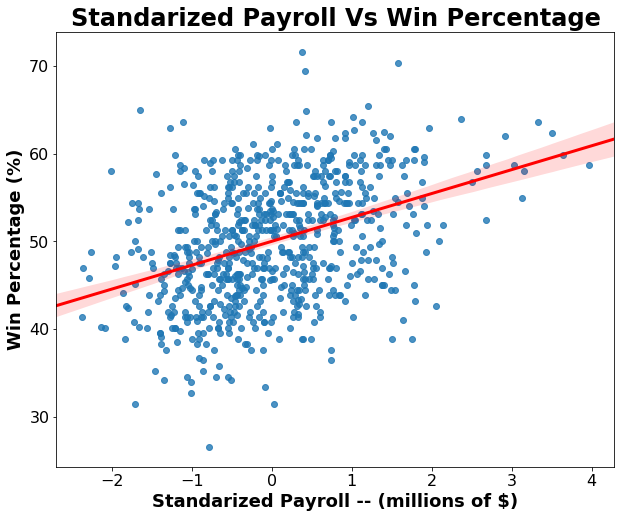

In [16]:
fig4,ax4 = plt.subplots(figsize=(10,8))
sns.regplot(x='Standarized_Payroll', y='Win_Percentage', data=Final, truncate=False, line_kws={"color":"red","lw":3})
ax4.set_title("Standarized Payroll Vs Win Percentage",fontsize=24,fontweight='bold')
ax4.set_xlabel("Standarized Payroll -- (millions of $)", fontsize=18, fontweight='bold')
ax4.set_ylabel("Win Percentage (%)",fontsize=18,fontweight='bold')
ax4.tick_params(labelsize=16)
plt.show()
fig4.savefig("Standarized_Payroll.png")

### <font color='red'>Comments on Plot</font>
* We can notice that after applying the Standarization, The __range__ of payrolls is normalized in a range from __(-3,4).__
* The __mean__ payroll is now __centered at 0__ and the __standard deviation__ is now __1.__
* Having done this standardized transformation makes it __easy to compare the points__ because they are all on the __same normal scale.__

## Expected wins

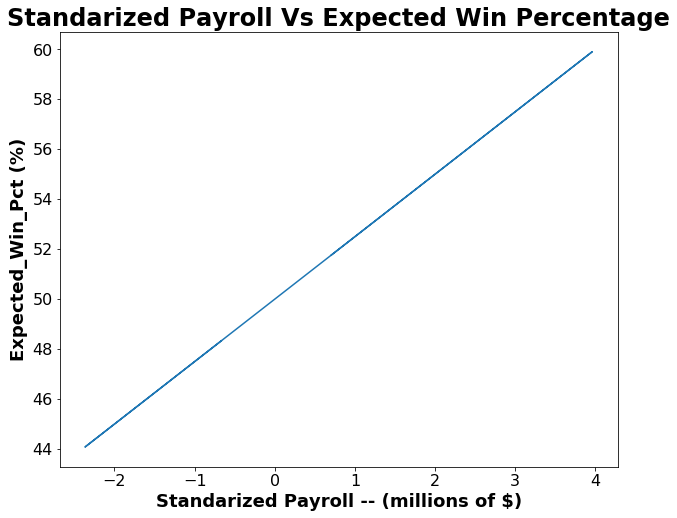

In [17]:
Final['Expected_Win_Pct'] = 50 + (2.5*Final.Standarized_Payroll)

fig5,ax5 = plt.subplots(figsize=(10,8))
ax5.plot(Final.Standarized_Payroll, Final.Expected_Win_Pct)
ax5.set_title("Standarized Payroll Vs Expected Win Percentage",fontsize=24,fontweight='bold')
ax5.set_xlabel("Standarized Payroll -- (millions of $)", fontsize=18, fontweight='bold')
ax5.set_ylabel("Expected_Win_Pct (%)",fontsize=18,fontweight='bold')
ax5.tick_params(labelsize=16)
plt.show()
fig5.savefig("Expected_Win_Pct.png")


## Spending efficiency

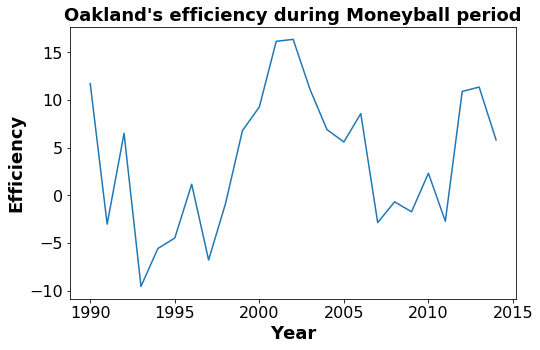

In [18]:
Final['Efficiency'] = Final.Win_Percentage - Final.Expected_Win_Pct
OAK = Final[Final['teamID'] == 'OAK']
fig6,ax6 = plt.subplots(figsize=(8,5))
# sns.regplot(x='Expected_Win_Pct', y='Win_Percentage', data=Final, truncate=False, line_kws={"color":"red","lw":3})
ax6.plot(OAK.yearID,OAK.Efficiency)
ax6.set_title("Oakland's efficiency during Moneyball period",fontsize=18,fontweight='bold')
ax6.set_xlabel("Year", fontsize=18, fontweight='bold')
ax6.set_ylabel("Efficiency",fontsize=18,fontweight='bold')
ax6.tick_params(labelsize=16)
plt.show()
fig6.savefig("Oakland's efficiency.png")

#### <font color='red'>Q : How good was Oakland's efficiency during the Moneyball period? </font>
* We can see in the plot above that Oakland's efficiency was almost __good__ as __most of the time it's efficiency is above 0__<br> 
* Its efficiency reached it's __peak__ during the __2002 season.__